In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Tiny dataset
# !gdown https://drive.google.com/uc?id=1qYPCnXXxjEcHEg3tLGt3fDkd2ialAgS4
import os
# Full dataset with jpeg
!gdown https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7

# Full dataset without jpeg
# https://drive.google.com/file/d/1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL/view?usp=share_link
# !gdown https://drive.google.com/uc?id=1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL
!unzip data_v1.zip -d /content/data > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7
To: /content/data_v1.zip
100% 640M/640M [00:04<00:00, 152MB/s]


In [3]:
%cd /content/data 
import json
data = json.load(open("train_data.json", "r"))

/content/data


In [4]:
data['annotations'][0]

{'id': 0,
 'image_id': 2,
 'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
 'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}

# Vocab

In [5]:
import json
vocab = json.load(open("/content/drive/MyDrive/IC/ResNet/vocab.json", encoding = 'utf-8'))
itos = list(vocab['stoi'])

In [6]:
def batch_decode(predictions_ids):
    preds = []
    for seq in predictions_ids:
        preds.append(" ".join([itos[id] for id in seq if id not in [0,1,2,3]]))
    return preds

# Dataset

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
import os

class IMCP_Test_Dataset(Dataset):
  def __init__(self, image_path = "public-test-images", summary_path = "test_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r", encoding = 'utf-8'))
    self.image_path = image_path
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, index):
    entry = self.data['images'][index]
    image_id = entry['id']
    image_name = entry['filename']
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = [self.data['annotations'][i]['segment_caption'] for i in range(len(self.data['annotations'])) if self.data['annotations'][i]['image_id'] == image_id]
    return image, caption, image_id

In [8]:
test_dataset = IMCP_Test_Dataset()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# Collator

In [10]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
max_seq_length = 256
class IMCP_Collator:
  def __init__(self, vocab, train = True, model = "resnet101"):
    self.vocab = vocab['stoi']
    self.bos_id = self.vocab['<bos>']
    self.eos_id = self.vocab['<eos>']
    self.pad_id = self.vocab['<pad>']
    self.model = model
    self.train = train

  def tokenize_texts(self, captions):
    raw_captions = [caption.split(" ") for caption in captions]
    truncated_captions = [s[:max_seq_length] for s in raw_captions]
    max_len = max([len(c) for c in truncated_captions])

    padded_captions = []
    for c in truncated_captions:
        c = [self.vocab[word] for word in c]
        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))
        padded_captions.append(seq)

    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
    padded_captions = pad_sequence(padded_captions, batch_first=True)
    return padded_captions
  
  def resize_and_stack(self, images):
    if self.model == "resnet101":
      image_tensors = []
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])
      
      for image in images:
        img_tensor = transform(image)
        image.close()
        image_tensors.append(img_tensor)
        
      stacked = torch.stack(image_tensors)
      return stacked
    else:
      pass

  def __call__(self, batch):
    if self.train:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), self.tokenize_texts(captions)
    else:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      image_ids = [example[2] for example in batch]
      return self.resize_and_stack(images), captions, image_ids
    

In [11]:
collatorTest = IMCP_Collator(vocab, train = False, model = "resnet101")

# DataLoader

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collatorTest)

# Model

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained RestNet101 model
encoder = models.resnet101(pretrained=True).to(device)

# Remove the last layer of the model
modules = list(encoder.children())[:-1]
encoder = nn.Sequential(*modules)

# Freeze the parameters of the model
for param in encoder.parameters():
    param.requires_grad = False

# Define LSTM decoder
class Decoder(nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + feature_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.squeeze().unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs
    
    def generate(self, features, max_length):
        batch_size = features.size(0)        
        input = torch.empty(batch_size, 1, device = device, dtype = torch.long).fill_(collatorTest.bos_id)
        track_complete_example = torch.zeros(batch_size)
        hidden = None
        cell = None
        # Loop through all the time steps
        for t in range(max_length - 1):
            embeddings = self.embed(input)
            features2 = features.squeeze(-1).squeeze(-1).unsqueeze(1).repeat(1, embeddings.size(1), 1)
            embeddings = torch.cat((features2, embeddings), 2)
            if t == 0:
                _, (hidden, cell) = self.lstm(embeddings)
            else:
                _, (hidden, cell) = self.lstm(embeddings, (hidden, cell))

            pred = torch.argmax(self.linear(hidden), axis = -1)
            input = torch.cat([input, pred.permute(1, 0)], dim = 1)
            where_end = torch.where(pred == collatorTest.pad_id)[0]
            track_complete_example[where_end] = 1
            if track_complete_example.eq(1).all():
              print("Early break in generate!")
              break

        return input


# Define hyperparameters
num_epochs = 2
embed_size = 256
feature_size = 2048
hidden_size = 512
vocab_size = len(vocab['stoi'].keys()) + 5
num_layers = 1

# Initialize decoder
decoder = Decoder(feature_size, embed_size, hidden_size, vocab_size, num_layers).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 205MB/s]


# Inference

In [14]:
decoder.load_state_dict(torch.load('/content/drive/MyDrive/IC/ResNet/decoder.pth'))

<All keys matched successfully>

In [15]:
my_preds = []
targets = []
data = []
decoder.eval()
encoder.eval()
for i, (images, captions, image_ids) in enumerate(test_dataloader):
    images = images.to(device)
    # Forward pass
    features = encoder(images)
    out = decoder.generate(features, 30)
    preds = out.detach().cpu().numpy()
    preds = batch_decode(preds)
    my_preds.extend(preds)
    for pred, image_id in zip(preds, image_ids):
        data.append({
            "image_id": image_id,
            "caption": pred
        })
    targets.extend(captions)
import json
with open("result_resnetlstm.json", "w") as file:
    json.dump(data, file, ensure_ascii = False)

In [16]:
import matplotlib.pyplot as plt

def image_captioning(image_name: str):
    image = Image.open(image_name).convert('RGB')
    plt.imshow(image)
    images = collatorTest.resize_and_stack([image])
    images = images.to(device)
    features = encoder(images)
    out = decoder.generate(features, 30)
    preds = out.detach().cpu().numpy()
    plt.title(batch_decode(preds)[0])
    plt.show()

Early break in generate!


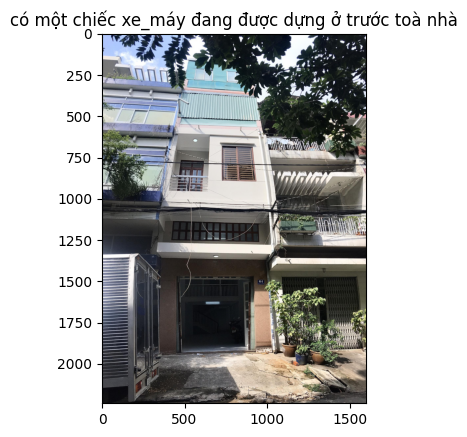

Early break in generate!


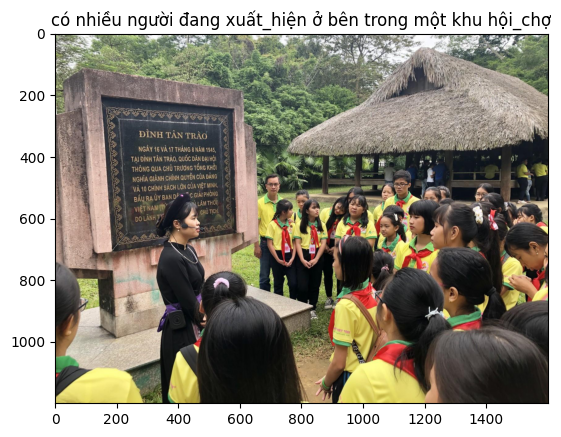

Early break in generate!


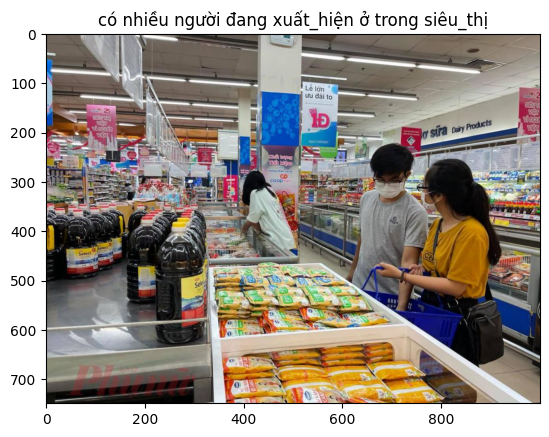

Early break in generate!


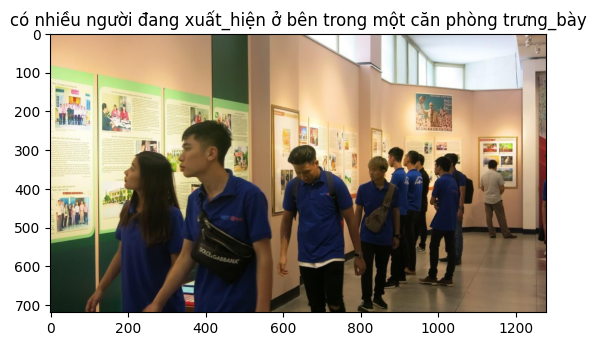

Early break in generate!


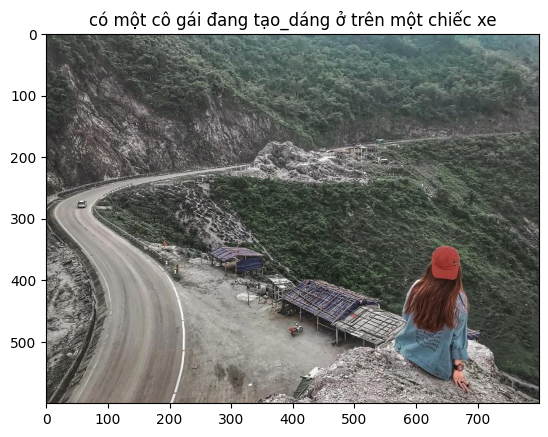

Early break in generate!


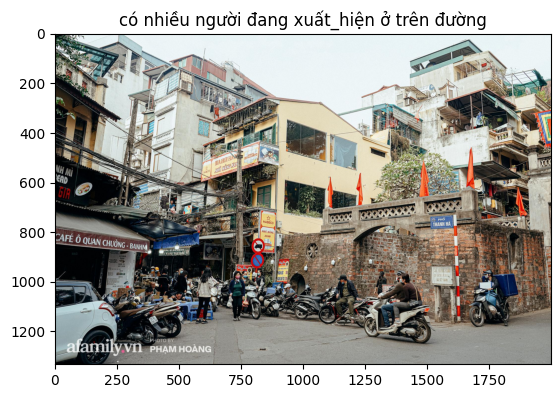

Early break in generate!


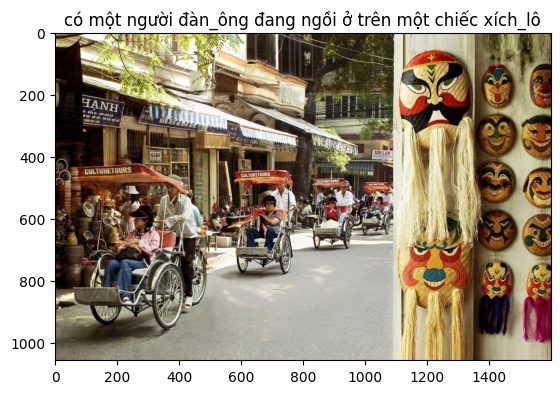

Early break in generate!


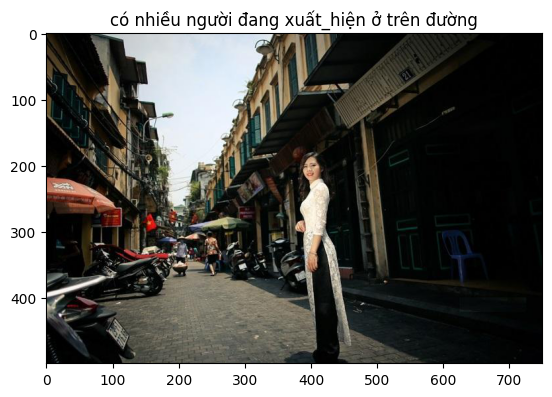

Early break in generate!


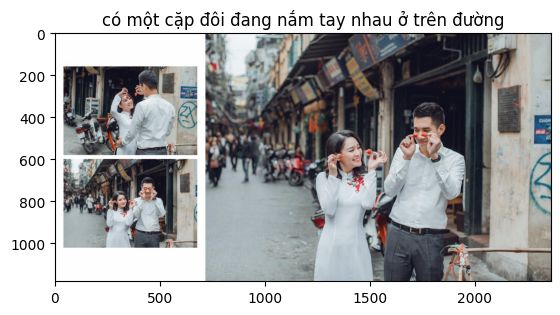

Early break in generate!


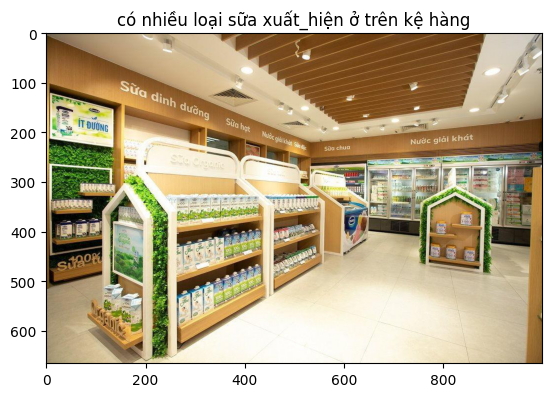

Early break in generate!


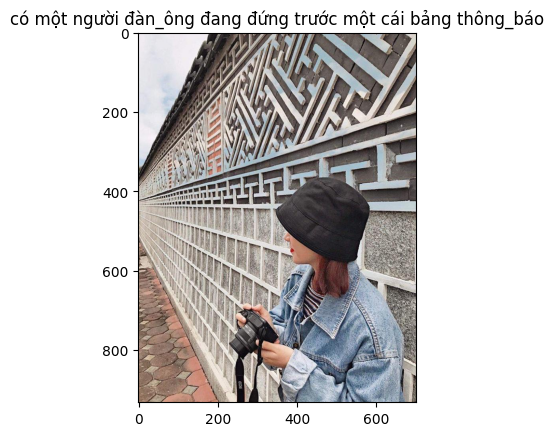

Early break in generate!


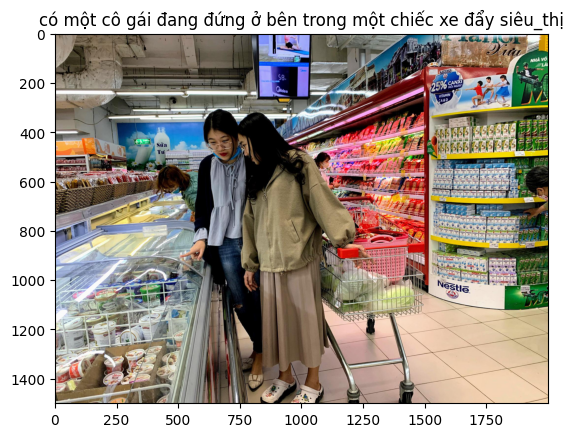

Early break in generate!


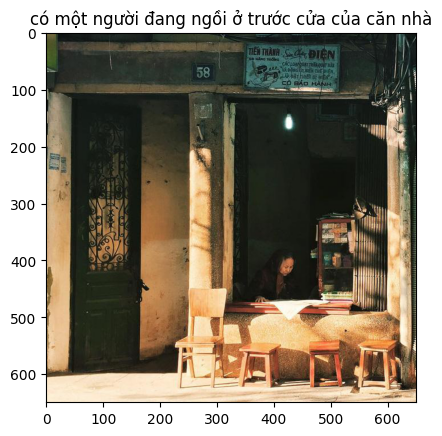

Early break in generate!


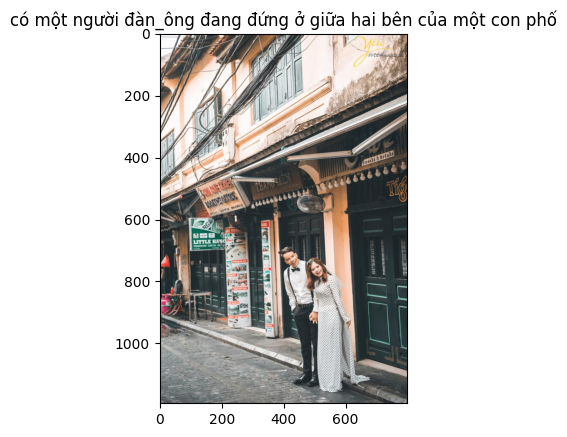

Early break in generate!


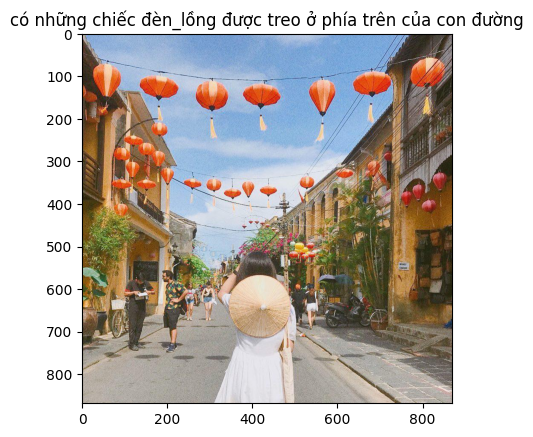

Early break in generate!


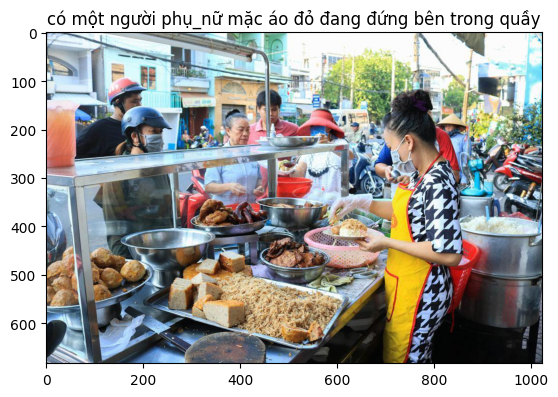

In [17]:
image_captioning("public-test-images/00000000001.jpg")
image_captioning("public-test-images/00000000078.jpg")
image_captioning("public-test-images/00000000115.jpg")
image_captioning("public-test-images/00000000118.jpg")
image_captioning("public-test-images/00000000190.jpg")
image_captioning("public-test-images/00000000322.jpg")
image_captioning("public-test-images/00000000331.jpg")
image_captioning("public-test-images/00000000363.jpg")
image_captioning("public-test-images/00000000490.jpg")
image_captioning("public-test-images/00000000657.jpg")
image_captioning("public-test-images/00000000702.jpg")
image_captioning("public-test-images/00000000834.jpg")
image_captioning("public-test-images/00000001052.jpg")
image_captioning("public-test-images/00000001109.jpg")
image_captioning("public-test-images/00000009770.jpg")
image_captioning("public-test-images/00000011015.jpeg")

In [18]:
# torch.save(decoder.state_dict(), 'res/my_model.pth')

In [19]:
# for step, data in enumerate(train_dataloader):
#   images = data['images'].to(device)
#   out = model.generate(images)
#   print(out)
#   break